In [1]:
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM
import torch
import random

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [19]:
class Movie:
    def __init__(self, name):
        self.name = name
        self.getContents()
        self.seperate_scenes()
        self.characters_per_scene()
        
    def getContents(self):
        with open(self.name,'r') as f:
            movie_contents = f.readlines()
        contents = []
        for content in movie_contents:
            content = content.strip('\n').strip()
            if content:
                contents.append(content)
        i = 1
        while i:
            if not contents[i][0].isupper() and contents[i][0]!='=' and 'INT' not in contents[i] and 'EXT' not in contents[i]:
                contents[i-1] += ' ' + contents[i]
                del contents[i]
            else:
                i+=1
            if i>=len(contents):
                i = 0
        self.contents = contents
        _, speaker, _ = self.extract_sentence(self.contents)
        self.speaker = set(speaker)
    
    def extract_sentence(self, contents):
        dialog, speaker, contents = self.seperate_dialog(contents)
        new_contents = []
        for content in contents:
            if '.' in content:
                for con in content.split('.'):
                    if con:
                        new_contents.append(con+'.')
            else:
                new_contents.append(content)
        return dialog, speaker, new_contents
    
    def seperate_dialog(self,contents):
        dialog = []
        speaker = []
        nor_sent = []
        stop_words = ['-',":","CONTINUE","END","NEARBY","OUTSIDE"]
        swit = 0
        for i in range(len(contents)):
            if swit:
                swit = 0
                continue
            text = contents[i]
            if any(word in text for word in stop_words):
                continue
            text = re.sub(r'\([^)]*\)', '', text).strip()
            #text = text.replace('.','')
            if text.isupper() and text.count(' ')<2 and i+1!=len(contents) and '!' not in text:
                speaker.append(re.sub('[^a-zA-Z]','',text).replace(' ',''))
                dialog.append(contents[i+1])
                swit = 1
                continue
            nor_sent.append(contents[i])
        return dialog, speaker, nor_sent
    
    def seperate_scenes(self):
        stop_words = ['INT','EXT']
        scenes =[]
        scene = []
        start = 1
        for cont in self.contents:
            if any(word in cont for word in stop_words):
                if start:
                    start = 0
                    scene = []
                    continue
                if scene:
                    scene.append(cont.replace('=','')[:-1])
                    scenes.append(scene)
                scene = []
                continue
            if cont:    
                scene.append(cont)
            
        self.scenes = scenes
        
    def characters_per_scene(self):
        self.scene_dict = {}
        for i, scene in enumerate(self.scenes):
            char_sent = {}
            dialog, speaker, nor_sent = self.extract_sentence(scene)
            for char, dia in zip(speaker, dialog):
                if char not in char_sent.keys():
                    char_sent[char] = [dia]
                else:
                    char_sent[char] += [dia]
            for sent in nor_sent:
                for char in self.speaker:
                    if char.lower()+' ' in sent.lower() or char.lower()+'.' in sent.lower():
                        if char not in char_sent.keys():
                            char_sent[char] = [sent]
                        else:
                            char_sent[char] += [sent]
            self.scene_dict[i+1] = char_sent
    
    def find_maincharacter_name(self, num=5):
        speaker = []
        for scene in self.scene_dict.values():
            for char in scene:
                speaker.append(char)
        num_occur = Counter(speaker)
        main_characters_list = num_occur.most_common(num)
        main_characters = []
        for character, count in main_characters_list:
            main_characters.append(character)
        return main_characters
    

In [3]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.decomposition import PCA


In [4]:
model = AutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

In [5]:
def transform_and_normalize(vecs, kernel, bias):
    """
        Applying transformation then standardize
    """
    if not (kernel is None or bias is None):
        vecs = (vecs + bias).dot(kernel)
    return normalize(vecs)
    
def normalize(vecs):
    """
        Standardization
    """
    return vecs / (vecs**2).sum(axis=1, keepdims=True)**0.5
    
def compute_kernel_bias(vecs):
    """
    Calculate Kernal & Bias for the final transformation - y = (x + bias).dot(kernel)
    """
    vecs = np.concatenate(vecs, axis=0)
    mu = vecs.mean(axis=0, keepdims=True)
    cov = np.cov(vecs.T)
    u, s, vh = np.linalg.svd(cov)
    W = np.dot(u, np.diag(s**0.5))
    W = np.linalg.inv(W.T)
    return W, -mu

def make_embedding(sentences):
    vecs = []
    with torch.no_grad():

        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True,  max_length=64)

            hidden_states = model(**inputs, return_dict=True, output_hidden_states=True).hidden_states

            #Averaging the first & last hidden states
            output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)

            vec = output_hidden_state.cpu().numpy()[0]

            vecs.append(vec)
    return vecs

def Dim_reduction(vecs, kernel = None, bias = None):
    '''
        This method will accept array of sentences, roberta tokenizer & model
        next it will call methods for dimention reduction
    '''
    
    kernel = kernel[:, :128]
    #If you want to reduce it to 128 dim
    #kernel = kernel[:, :128]
    embeddings = []
    embeddings = np.vstack(vecs)

    #Sentence embeddings can be converted into an identity matrix
    #by utilizing the transformation matrix
    embeddings = transform_and_normalize(embeddings, 
                kernel=kernel,
                bias=bias
            )

    return embeddings

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

2022-09-29 10:53:30.440847: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 10:53:31.210741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 10:53:31.212141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64
2022-09-29 10:53:31.212235: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would lik

In [7]:
from gensim.models import Word2Vec
import csv

In [8]:
def read_graph(edgeList,weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('weight',float),('id',int)), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('id',int)), create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1.0

    if not directed:
        G = G.to_undirected()

    # print (G.edges(data = True))
    return G


In [9]:
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    '''  '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

   

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return sinusoid_table

In [10]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act","act","scene","act"],
#    ["char","act","act","char"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]

metapaths2 = [
    ['char','act','scene','act','char']
#    ['char','act','act','scene','act','act','char']
]

metapaths3 = [
    ['scene','act','act','char','act','act','scene'],
    ['char','act','act','scene','act','act','char']
]
positional = get_sinusoid_encoding_table(500,16)

In [11]:
transform = PCA  # PCA

trans = transform(n_components=2)

In [12]:
path = 'data/scriptbase/'
filenames = os.listdir(path)

Oceans Eleven
Number of random walks: 8286
[87, 88, 89, 91, 93, 95, 122, 123, 142, 163, 211, 212, 217, 218, 224, 251, 258, 260, 261]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]


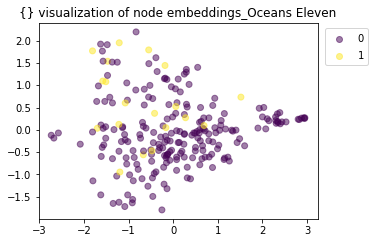

In [43]:
mov_emb = {}
name = 'Oceans Eleven'
print(name)
mov_scene = {}
mov = Movie('data/scriptbase/'+name+'/script.txt')
scene_embedding = {}
total_embedding = []
total_sentence = []
main_char = mov.find_maincharacter_name(num=10)

pro = 'TESS'

pro_scene = []


for num, scene in mov.scene_dict.items():
    if pro in scene.keys():
        pro_scene.append(num)


for i, char_dict in mov.scene_dict.items():
    scene = {}
    for char, sent in char_dict.items():
        emb = make_embedding(sent)
        scene[char] = [emb,sent]       
        total_embedding += emb
        total_sentence +=sent
    scene_embedding[i] = scene
    
emb_act = []
g_list = []
id_num = 1
node_embedding = {}
total_act = []
for i, (scene, contents) in enumerate(scene_embedding.items()):
    #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
    #if i != len(scene_embedding_reduction.items())-1:
    #    g_list.append([line])
    #id_num +=1 
    sent_num = 1
    sentnum_emb = {}
    sentnum_sent = {}
    total_sent = 0
    for char, (embs,sent) in contents.items():
        total_sent += len(embs)
    for char, (embs,sent) in contents.items():   
        char_len = len(embs)
        for emb,s in zip(embs,sent):
            sentnum_emb[sent_num] = emb
            sentnum_sent[sent_num] = s
            line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
            total_act.append(str(scene) + '_act_' + str(sent_num))
            node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
            id_num += 1
            g_list.append([line])
            line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
            id_num += 1
            sent_num += 1
            g_list.append([line])
    
    if sent_num!=1:     
        for j in range(1,sent_num):
            for k in range(j+1,sent_num):
                if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                    score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                    if score > 0.6 and score< 0.99:
                        #print(name, sentnum_sent[j])
                        node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                        node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])
        
        
with open('test.csv', 'w',newline='') as f: 
    write = csv.writer(f)    
    write.writerows(g_list)
g= read_graph('test.csv')
attr = {}
for node in g.nodes():
    if 'scene' in node:
        attr[node]='scene'
    elif 'act' in node:
        attr[node]='act'
    elif 'char' in node:
        attr[node]='char'
nx.set_node_attributes(g, attr,"label")
stellar_g = StellarGraph.from_networkx(g)
stellar_g.info()

   # Create the random walker
rw = UniformRandomMetaPathWalk(stellar_g)
walks1 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
walks2 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length*2,  # maximum length of a random walk
    n=60,  # number of random walks per root node
    metapaths=metapaths2,  # the metapaths
)

walks3 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths3,  # the metapaths
)
walks = []
for w in walks1:
    if len(w)>1:
        walks.append(w)
for w in walks2:
    if len(w)>1:
        walks.append(w)
for w in walks3:
    if len(w)>1:
        walks.append(w)

print("Number of random walks: {}".format(len(walks))) 

w2v = Word2Vec(vector_size=400, window=5, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])
for key in w2v.wv.index_to_key:
    if key in node_embedding.keys():
        w2v.wv[key] = node_embedding[key]
        
random.shuffle(walks)
w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
# Retrieve node embeddings and corresponding subjects
node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
node_ids.sort()
node_ids.sort(key=len)
node_embeddings = (
    w2v.wv[node_ids]
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

mov_emb[name] = node_embeddings

node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
node_embeddings_2d = trans.fit_transform(node_embeddings)
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [0 for i in node_targets]


print(pro_scene)
for i in pro_scene:
    for num, node_id in enumerate(node_ids):
        if int(node_id[6:]) == i:
            node_colours[num] = 1

color = 0
last = 0
#print(len(node_ids), len(node_colours))

mov_scene[name] = node_ids
print(node_colours)
plt.figure(figsize=(5, 4))
plt.axes().set(aspect="equal")
X = node_embeddings_2d[:, 0]
Y = node_embeddings_2d[:, 1]
scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
#for i, label in enumerate(node_ids):
#    plt.annotate(label, (X[i], Y[i]))

#plt.savefig(name+'.png',dpi=300)  
plt.show()

Oceans Eleven
mean 		 scene_1 		 Score: 0.7010
mean 		 scene_2 		 Score: 0.7222
mean 		 scene_4 		 Score: 0.9491
mean 		 scene_6 		 Score: 0.6628
mean 		 scene_7 		 Score: 0.6712
mean 		 scene_8 		 Score: 0.6870
mean 		 scene_9 		 Score: 0.7859
mean 		 scene_10 		 Score: 0.7711
mean 		 scene_11 		 Score: 0.7374
mean 		 scene_12 		 Score: 0.6967
mean 		 scene_13 		 Score: 0.7186
mean 		 scene_14 		 Score: 0.6661
mean 		 scene_15 		 Score: 0.7266
mean 		 scene_16 		 Score: 0.6703
mean 		 scene_17 		 Score: 0.7464
mean 		 scene_19 		 Score: 0.6188
mean 		 scene_20 		 Score: 0.7334
mean 		 scene_21 		 Score: 0.7296
mean 		 scene_22 		 Score: 0.7377
mean 		 scene_23 		 Score: 0.7217
mean 		 scene_24 		 Score: 0.8966
mean 		 scene_25 		 Score: 0.6553
mean 		 scene_26 		 Score: 0.7394
mean 		 scene_27 		 Score: 0.7635
mean 		 scene_28 		 Score: 0.6557
mean 		 scene_29 		 Score: 0.6634
mean 		 scene_30 		 Score: 0.7696
mean 		 scene_31 		 Score: 0.6262
mean 		 scene_32 		 Score: 0.7495
mean 		

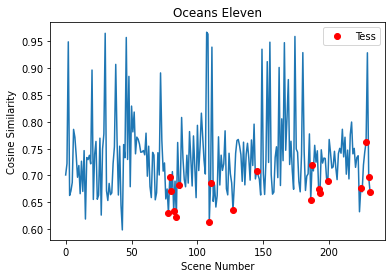

Oceans Eleven 전체 평균 tensor([[0.7342]]) B스토리 평균 tensor([[0.6733]]) B스토리 제외 평균 tensor([[0.7397]])
213 19 232


In [53]:
for movie_name in mov_emb.keys():
    print(movie_name)
    pairs = []
    scene_nums = []
    scores = []
    critical_point = 0
    mean = torch.mean(torch.tensor(mov_emb[movie_name]),dim=0)
    for scene_num, emb in enumerate(mov_emb[movie_name]):
        score = util.cos_sim(mean,emb)   
        pairs.append({'index': scene_num, 'score': score})

    pairs = sorted(pairs, key=lambda x: x['index'], reverse=False)
    #    pred = []
    for k, pair in enumerate(pairs):
        scene_num = pair['index']
        print("mean \t\t {} \t\t Score: {:.4f}".format(mov_scene[movie_name][scene_num], pair['score'].item()))
        scene_nums.append(pair['index'])
        scores.append(pair['score'])
        if pair['score']> 0.9 and critical_point == 0:
            critical_point = mov_scene[movie_name][scene_num]

    #    if pair['score']>0.9:
    #        break
    #        pred.append(node[j])  
    
    x = scene_nums
    y = scores
    x_p = []
    y_p = []
    y_p_except = []
    for i, num in enumerate(scene_nums):
        for pro in pro_scene:            
            if int(mov_scene[movie_name][num][6:])==pro:
                x_p.append(num)
                y_p.append(scores[i])
                
    for score in y:
        if score not in y_p:
            y_p_except.append(score)
    plt.plot(x,y)
    plt.plot(x_p,y_p,'o',color='red',label='Tess')
    plt.legend()
    plt.xlabel('Scene Number')
    plt.ylabel('Cosine Similarity')
    plt.title(movie_name)
    plt.savefig(movie_name+'_Bstory.png',dpi=300)
    plt.show()
    print(movie_name, '전체 평균',sum(scores)/len(scores),'B스토리 평균',sum(y_p)/len(y_p),'B스토리 제외 평균',sum(y_p_except)/len(y_p_except))
    print(len(y_p_except),len(y_p),len(y))
    #    print(tripod[tripod['movie_name']==movie_name]['tp1'],tripod[tripod['movie_name']==movie_name]['tp2'])
            
    #    score[node[scene_num]].append(pred)

Eternal Sunshine of the Spotless Mind
Number of random walks: 6876
[4, 5, 25, 26, 32, 33, 46, 58, 61, 63, 70, 74, 76, 79, 82, 84, 91, 94, 95, 105, 129, 130, 134, 135, 140, 152, 154, 156, 158, 159]
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]


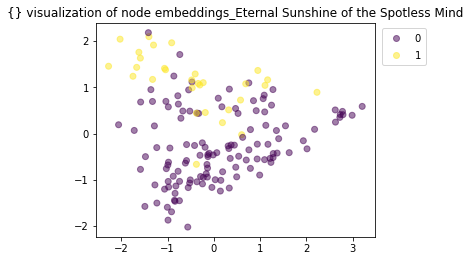

In [54]:
mov_emb = {}
name = 'Eternal Sunshine of the Spotless Mind'
print(name)
mov_scene = {}
mov = Movie('data/scriptbase/'+name+'/script.txt')
scene_embedding = {}
total_embedding = []
total_sentence = []
main_char = mov.find_maincharacter_name(num=10)

pro = 'MARY'
pro2 = 'MIERZWIAK'

pro_scene = []


for num, scene in mov.scene_dict.items():
    if pro in scene.keys():
        pro_scene.append(num)


for i, char_dict in mov.scene_dict.items():
    scene = {}
    for char, sent in char_dict.items():
        emb = make_embedding(sent)
        scene[char] = [emb,sent]       
        total_embedding += emb
        total_sentence +=sent
    scene_embedding[i] = scene
    
emb_act = []
g_list = []
id_num = 1
node_embedding = {}
total_act = []
for i, (scene, contents) in enumerate(scene_embedding.items()):
    #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
    #if i != len(scene_embedding_reduction.items())-1:
    #    g_list.append([line])
    #id_num +=1 
    sent_num = 1
    sentnum_emb = {}
    sentnum_sent = {}
    total_sent = 0
    for char, (embs,sent) in contents.items():
        total_sent += len(embs)
    for char, (embs,sent) in contents.items():   
        char_len = len(embs)
        for emb,s in zip(embs,sent):
            sentnum_emb[sent_num] = emb
            sentnum_sent[sent_num] = s
            line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
            total_act.append(str(scene) + '_act_' + str(sent_num))
            node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
            id_num += 1
            g_list.append([line])
            line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
            id_num += 1
            sent_num += 1
            g_list.append([line])
    
    if sent_num!=1:     
        for j in range(1,sent_num):
            for k in range(j+1,sent_num):
                if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                    score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                    if score > 0.6 and score< 0.99:
                        #print(name, sentnum_sent[j])
                        node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                        node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])
        
        
with open('test.csv', 'w',newline='') as f: 
    write = csv.writer(f)    
    write.writerows(g_list)
g= read_graph('test.csv')
attr = {}
for node in g.nodes():
    if 'scene' in node:
        attr[node]='scene'
    elif 'act' in node:
        attr[node]='act'
    elif 'char' in node:
        attr[node]='char'
nx.set_node_attributes(g, attr,"label")
stellar_g = StellarGraph.from_networkx(g)
stellar_g.info()

   # Create the random walker
rw = UniformRandomMetaPathWalk(stellar_g)
walks1 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
walks2 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length*2,  # maximum length of a random walk
    n=60,  # number of random walks per root node
    metapaths=metapaths2,  # the metapaths
)

walks3 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths3,  # the metapaths
)
walks = []
for w in walks1:
    if len(w)>1:
        walks.append(w)
for w in walks2:
    if len(w)>1:
        walks.append(w)
for w in walks3:
    if len(w)>1:
        walks.append(w)

print("Number of random walks: {}".format(len(walks))) 

w2v = Word2Vec(vector_size=400, window=5, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])
for key in w2v.wv.index_to_key:
    if key in node_embedding.keys():
        w2v.wv[key] = node_embedding[key]
        
random.shuffle(walks)
w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
# Retrieve node embeddings and corresponding subjects
node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
node_ids.sort()
node_ids.sort(key=len)
node_embeddings = (
    w2v.wv[node_ids]
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

mov_emb[name] = node_embeddings

node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
node_embeddings_2d = trans.fit_transform(node_embeddings)
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [0 for i in node_targets]


print(pro_scene)
for i in pro_scene:
    for num, node_id in enumerate(node_ids):
        if int(node_id[6:]) == i:
            node_colours[num] = 1

color = 0
last = 0
#print(len(node_ids), len(node_colours))

mov_scene[name] = node_ids
print(node_colours)
plt.figure(figsize=(5, 4))
plt.axes().set(aspect="equal")
X = node_embeddings_2d[:, 0]
Y = node_embeddings_2d[:, 1]
scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
#for i, label in enumerate(node_ids):
#    plt.annotate(label, (X[i], Y[i]))

#plt.savefig(name+'.png',dpi=300)  
plt.show()

Eternal Sunshine of the Spotless Mind
mean 		 scene_1 		 Score: 0.8050
mean 		 scene_2 		 Score: 0.7626
mean 		 scene_3 		 Score: 0.7618
mean 		 scene_4 		 Score: 0.6642
mean 		 scene_5 		 Score: 0.6420
mean 		 scene_6 		 Score: 0.6716
mean 		 scene_7 		 Score: 0.7524
mean 		 scene_8 		 Score: 0.7906
mean 		 scene_9 		 Score: 0.6776
mean 		 scene_10 		 Score: 0.7268
mean 		 scene_11 		 Score: 0.7457
mean 		 scene_12 		 Score: 0.7163
mean 		 scene_13 		 Score: 0.6326
mean 		 scene_14 		 Score: 0.7119
mean 		 scene_15 		 Score: 0.7438
mean 		 scene_16 		 Score: 0.7214
mean 		 scene_17 		 Score: 0.6499
mean 		 scene_18 		 Score: 0.6190
mean 		 scene_19 		 Score: 0.8143
mean 		 scene_20 		 Score: 0.7784
mean 		 scene_21 		 Score: 0.7167
mean 		 scene_22 		 Score: 0.6719
mean 		 scene_23 		 Score: 0.7440
mean 		 scene_24 		 Score: 0.8364
mean 		 scene_25 		 Score: 0.7552
mean 		 scene_26 		 Score: 0.7443
mean 		 scene_27 		 Score: 0.6501
mean 		 scene_28 		 Score: 0.7062
mean 		 scene_29 		

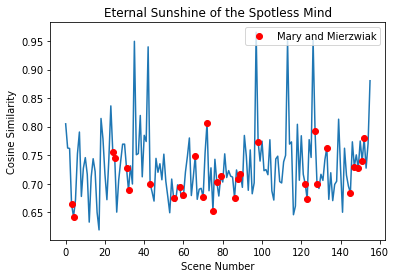

Eternal Sunshine of the Spotless Mind 전체 평균 tensor([[0.7308]]) B스토리 평균 tensor([[0.7144]]) B스토리 제외 평균 tensor([[0.7348]])
126 30 156


In [56]:
for movie_name in mov_emb.keys():
    print(movie_name)
    pairs = []
    scene_nums = []
    scores = []
    critical_point = 0
    mean = torch.mean(torch.tensor(mov_emb[movie_name]),dim=0)
    for scene_num, emb in enumerate(mov_emb[movie_name]):
        score = util.cos_sim(mean,emb)   
        pairs.append({'index': scene_num, 'score': score})

    pairs = sorted(pairs, key=lambda x: x['index'], reverse=False)
    #    pred = []
    for k, pair in enumerate(pairs):
        scene_num = pair['index']
        print("mean \t\t {} \t\t Score: {:.4f}".format(mov_scene[movie_name][scene_num], pair['score'].item()))
        scene_nums.append(pair['index'])
        scores.append(pair['score'])
        if pair['score']> 0.9 and critical_point == 0:
            critical_point = mov_scene[movie_name][scene_num]

    #    if pair['score']>0.9:
    #        break
    #        pred.append(node[j])  
    
    x = scene_nums
    y = scores
    x_p = []
    y_p = []
    y_p_except = []
    for i, num in enumerate(scene_nums):
        for pro in pro_scene:            
            if int(mov_scene[movie_name][num][6:])==pro:
                x_p.append(num)
                y_p.append(scores[i])
                
    for score in y:
        if score not in y_p:
            y_p_except.append(score)
    plt.plot(x,y)
    plt.plot(x_p,y_p,'o',color='red',label='Mary and Mierzwiak')
    plt.legend(loc='upper right')
    plt.xlabel('Scene Number')
    plt.ylabel('Cosine Similarity')
    plt.title(movie_name)
    plt.savefig(movie_name+'_Bstory.png',dpi=300)
    plt.show()
    print(movie_name, '전체 평균',sum(scores)/len(scores),'B스토리 평균',sum(y_p)/len(y_p),'B스토리 제외 평균',sum(y_p_except)/len(y_p_except))
    print(len(y_p_except),len(y_p),len(y))
#    print(tripod[tripod['movie_name']==movie_name]['tp1'],tripod[tripod['movie_name']==movie_name]['tp2'])
            
    #    score[node[scene_num]].append(pred)

Forrest Gump
['FORREST', 'JENNY', 'MAN', 'LTDAN', 'MRSGUMP', 'MEN', 'BUBBA', 'CROWD', 'BOY', 'ANCHORMAN']
Number of random walks: 10970
[1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193]
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

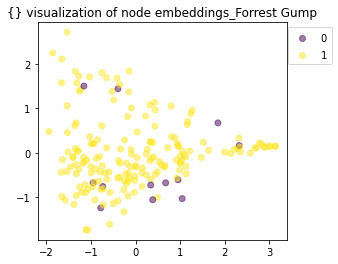

In [21]:
mov_emb = {}
name = 'Forrest Gump'
print(name)
mov_scene = {}
mov = Movie('data/scriptbase/'+name+'/script.txt')
scene_embedding = {}
total_embedding = []
total_sentence = []
main_char = mov.find_maincharacter_name(num=10)
print(main_char)
pro = 'JENNY'
pro = 'FORREST'

pro_scene = []


for num, scene in mov.scene_dict.items():
    if pro in scene.keys():
        pro_scene.append(num)


for i, char_dict in mov.scene_dict.items():
    scene = {}
    for char, sent in char_dict.items():
        emb = make_embedding(sent)
        scene[char] = [emb,sent]       
        total_embedding += emb
        total_sentence +=sent
    scene_embedding[i] = scene
    
emb_act = []
g_list = []
id_num = 1
node_embedding = {}
total_act = []
for i, (scene, contents) in enumerate(scene_embedding.items()):
    #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
    #if i != len(scene_embedding_reduction.items())-1:
    #    g_list.append([line])
    #id_num +=1 
    sent_num = 1
    sentnum_emb = {}
    sentnum_sent = {}
    total_sent = 0
    for char, (embs,sent) in contents.items():
        total_sent += len(embs)
    for char, (embs,sent) in contents.items():   
        char_len = len(embs)
        for emb,s in zip(embs,sent):
            sentnum_emb[sent_num] = emb
            sentnum_sent[sent_num] = s
            line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
            total_act.append(str(scene) + '_act_' + str(sent_num))
            node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
            id_num += 1
            g_list.append([line])
            line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
            id_num += 1
            sent_num += 1
            g_list.append([line])
    
    if sent_num!=1:     
        for j in range(1,sent_num):
            for k in range(j+1,sent_num):
                if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                    score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                    if score > 0.6 and score< 0.99:
                        #print(name, sentnum_sent[j])
                        node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                        node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])
        
        
with open('test.csv', 'w',newline='') as f: 
    write = csv.writer(f)    
    write.writerows(g_list)
g= read_graph('test.csv')
attr = {}
for node in g.nodes():
    if 'scene' in node:
        attr[node]='scene'
    elif 'act' in node:
        attr[node]='act'
    elif 'char' in node:
        attr[node]='char'
nx.set_node_attributes(g, attr,"label")
stellar_g = StellarGraph.from_networkx(g)
stellar_g.info()

   # Create the random walker
rw = UniformRandomMetaPathWalk(stellar_g)
walks1 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
walks2 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length*2,  # maximum length of a random walk
    n=60,  # number of random walks per root node
    metapaths=metapaths2,  # the metapaths
)

walks3 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths3,  # the metapaths
)
walks = []
for w in walks1:
    if len(w)>1:
        walks.append(w)
for w in walks2:
    if len(w)>1:
        walks.append(w)
for w in walks3:
    if len(w)>1:
        walks.append(w)

print("Number of random walks: {}".format(len(walks))) 

w2v = Word2Vec(vector_size=400, window=5, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])
for key in w2v.wv.index_to_key:
    if key in node_embedding.keys():
        w2v.wv[key] = node_embedding[key]
        
random.shuffle(walks)
w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
# Retrieve node embeddings and corresponding subjects
node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
node_ids.sort()
node_ids.sort(key=len)
node_embeddings = (
    w2v.wv[node_ids]
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

mov_emb[name] = node_embeddings

node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
node_embeddings_2d = trans.fit_transform(node_embeddings)
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [0 for i in node_targets]


print(pro_scene)
for i in pro_scene:
    for num, node_id in enumerate(node_ids):
        if int(node_id[6:]) == i:
            node_colours[num] = 1

color = 0
last = 0
#print(len(node_ids), len(node_colours))

mov_scene[name] = node_ids
print(node_colours)
plt.figure(figsize=(5, 4))
plt.axes().set(aspect="equal")
X = node_embeddings_2d[:, 0]
Y = node_embeddings_2d[:, 1]
scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
#for i, label in enumerate(node_ids):
#    plt.annotate(label, (X[i], Y[i]))

#plt.savefig(name+'.png',dpi=300)  
plt.show()

Forrest Gump
mean 		 scene_1 		 Score: 0.6573
mean 		 scene_2 		 Score: 0.7010
mean 		 scene_3 		 Score: 0.7277
mean 		 scene_4 		 Score: 0.7549
mean 		 scene_5 		 Score: 0.6489
mean 		 scene_6 		 Score: 0.6994
mean 		 scene_7 		 Score: 0.7491
mean 		 scene_8 		 Score: 0.7575
mean 		 scene_9 		 Score: 0.7129
mean 		 scene_10 		 Score: 0.7762
mean 		 scene_11 		 Score: 0.7315
mean 		 scene_12 		 Score: 0.6967
mean 		 scene_13 		 Score: 0.7292
mean 		 scene_14 		 Score: 0.6422
mean 		 scene_15 		 Score: 0.6601
mean 		 scene_16 		 Score: 0.7674
mean 		 scene_17 		 Score: 0.7193
mean 		 scene_18 		 Score: 0.6809
mean 		 scene_19 		 Score: 0.7275
mean 		 scene_20 		 Score: 0.6440
mean 		 scene_21 		 Score: 0.6801
mean 		 scene_22 		 Score: 0.6641
mean 		 scene_23 		 Score: 0.7413
mean 		 scene_24 		 Score: 0.6418
mean 		 scene_25 		 Score: 0.7574
mean 		 scene_26 		 Score: 0.7372
mean 		 scene_27 		 Score: 0.9587
mean 		 scene_28 		 Score: 0.7652
mean 		 scene_29 		 Score: 0.6628
mean 		 sc

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


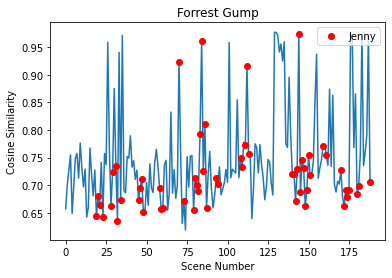

Forrest Gump 전체 평균 tensor([[0.7469]]) B스토리 평균 tensor([[0.7200]]) B스토리 제외 평균 tensor([[0.7583]])
133 56 189


In [14]:
for movie_name in mov_emb.keys():
    print(movie_name)
    pairs = []
    scene_nums = []
    scores = []
    critical_point = 0
    mean = torch.mean(torch.tensor(mov_emb[movie_name]),dim=0)
    for scene_num, emb in enumerate(mov_emb[movie_name]):
        score = util.cos_sim(mean,emb)   
        pairs.append({'index': scene_num, 'score': score})

    pairs = sorted(pairs, key=lambda x: x['index'], reverse=False)
    #    pred = []
    for k, pair in enumerate(pairs):
        scene_num = pair['index']
        print("mean \t\t {} \t\t Score: {:.4f}".format(mov_scene[movie_name][scene_num], pair['score'].item()))
        scene_nums.append(pair['index'])
        scores.append(pair['score'])
        if pair['score']> 0.9 and critical_point == 0:
            critical_point = mov_scene[movie_name][scene_num]

    #    if pair['score']>0.9:
    #        break
    #        pred.append(node[j])  
    
    x = scene_nums
    y = scores
    x_p = []
    y_p = []
    y_p_except = []

    for i, num in enumerate(scene_nums):
        for pro in pro_scene:            
            if int(mov_scene[movie_name][num][6:])==pro:
                x_p.append(num)
                y_p.append(scores[i])
    for score in y:
        if score not in y_p:
            y_p_except.append(score)
                
    plt.plot(x,y)
    plt.plot(x_p,y_p,'o',color='red',label='Jenny')
    plt.legend(loc='upper right')
    plt.xlabel('Scene Number')
    plt.ylabel('Cosine Similarity')
    plt.title(movie_name)
    plt.savefig(movie_name+'_Bstory.png',dpi=300)
    plt.show()
    print(movie_name, '전체 평균',sum(scores)/len(scores),'B스토리 평균',sum(y_p)/len(y_p),'B스토리 제외 평균',sum(y_p_except)/len(y_p_except))
    print(len(y_p_except),len(y_p),len(y))
#    print(tripod[tripod['movie_name']==movie_name]['tp1'],tripod[tripod['movie_name']==movie_name]['tp2'])
            
    #    score[node[scene_num]].append(pred)

In [15]:
class Movie:
    def __init__(self, name):
        self.name = name
        self.getContents()
        self.seperate_scenes()
        self.characters_per_scene()
        
    def getContents(self):
        with open(self.name,'r') as f:
            movie_contents = f.readlines()
        contents = []
        for content in movie_contents:
            content = content.strip('\n').strip()
            if ':' in content and content:
                cont1,cont2 = content.split(':')
                contents.append(cont1.upper())
                contents.append(cont2)
                continue
            if '(' in content and content:
                contents.append('(')
                contents.append(content[1:])
                continue
            if content:
                contents.append(content)
        i = 1
        while i:
            if not contents[i][0].isupper() and not contents[i-1].isupper():
                contents[i-1] += ' ' + contents[i]
                del contents[i]
            else:
                i+=1
            if i>=len(contents):
                i = 0
        self.contents = contents
        _, speaker, _ = self.extract_sentence(self.contents)
        self.speaker = set(speaker)
    
    def extract_sentence(self, contents):
        dialog, speaker, contents = self.seperate_dialog(contents)
        new_contents = []
        for content in contents:
            if '.' in content:
                for con in content.split('.'):
                    if con:
                        new_contents.append(con+'.')
            else:
                new_contents.append(content)
        return dialog, speaker, new_contents
    
    def seperate_dialog(self,contents):
        dialog = []
        speaker = []
        nor_sent = []
        stop_words = ['-',":","CONTINUE","END","NEARBY","OUTSIDE"]
        swit = 0
        for i in range(len(contents)):
            if swit:
                swit = 0
                continue
            text = contents[i]
            if any(word in text for word in stop_words):
                continue
            text = re.sub(r'\([^)]*\)', '', text).strip()
            #text = text.replace('.','')
            if text.isupper() and text.count(' ')<2 and i+1!=len(contents) and '!' not in text:
                speaker.append(re.sub('[^a-zA-Z]','',text).replace(' ',''))
                dialog.append(contents[i+1])
                swit = 1
                continue
            nor_sent.append(contents[i])
        return dialog, speaker, nor_sent
    
    def seperate_scenes(self):
        stop_words = ['(']
        scenes =[]
        scene = []
        start = 1
        for cont in self.contents:
            if any(word in cont for word in stop_words):
                if start:
                    start = 0
                    scene = []
                    continue
                if scene:
                    scene.append(cont.replace('=','')[:-1])
                    scenes.append(scene)
                scene = []
                continue
            if cont:    
                scene.append(cont)
            
        self.scenes = scenes
        
    def characters_per_scene(self):
        self.scene_dict = {}
        for i, scene in enumerate(self.scenes):
            char_sent = {}
            dialog, speaker, nor_sent = self.extract_sentence(scene)
            for char, dia in zip(speaker, dialog):
                if char not in char_sent.keys():
                    char_sent[char] = [dia]
                else:
                    char_sent[char] += [dia]
            for sent in nor_sent:
                for char in self.speaker:
                    if char.lower()+' ' in sent.lower() or char.lower()+'.' in sent.lower():
                        if char not in char_sent.keys():
                            char_sent[char] = [sent]
                        else:
                            char_sent[char] += [sent]
            self.scene_dict[i+1] = char_sent
    
    def find_maincharacter_name(self, num=5):
        speaker = []
        for scene in self.scene_dict.values():
            for char in scene:
                speaker.append(char)
        num_occur = Counter(speaker)
        main_characters_list = num_occur.most_common(num)
        main_characters = []
        for character, count in main_characters_list:
            main_characters.append(character)
        return main_characters
    

When Harry Met Sally...
['SALLY', 'HARRY', 'MARIE', 'JESS', 'MAN', 'WOMAN', 'JOE', 'ALICE', 'HELEN', 'AMANDA']
Number of random walks: 5363
[49, 50, 51, 52, 53, 89, 90, 99, 101, 102, 103, 105, 106, 110, 111, 112, 123, 124, 125, 126, 130, 131, 132, 133, 134, 135, 136, 139, 141, 143, 157, 158, 159, 165, 166, 176, 179, 185, 199, 200]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


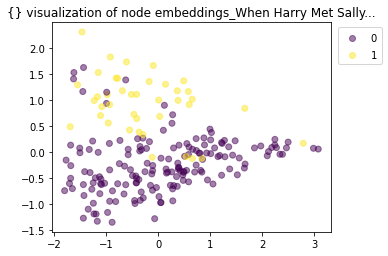

In [16]:
mov_emb = {}
name = 'When Harry Met Sally...'
print(name)
mov_scene = {}
mov = Movie('data/scriptbase/'+name+'/script.txt')
scene_embedding = {}
total_embedding = []
total_sentence = []
main_char = mov.find_maincharacter_name(num=10)
print(main_char)
pro = 'JESS'
pro2 = 'MARIE'
no_pro = 'HARRY'
no_pro2 = 'SALLY'
pro_scene = []


for num, scene in mov.scene_dict.items():
    if pro in scene.keys():
        pro_scene.append(num)


for i, char_dict in mov.scene_dict.items():
    scene = {}
    for char, sent in char_dict.items():
        emb = make_embedding(sent)
        scene[char] = [emb,sent]       
        total_embedding += emb
        total_sentence +=sent
    scene_embedding[i] = scene
    
emb_act = []
g_list = []
id_num = 1
node_embedding = {}
total_act = []
for i, (scene, contents) in enumerate(scene_embedding.items()):
    #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
    #if i != len(scene_embedding_reduction.items())-1:
    #    g_list.append([line])
    #id_num +=1 
    sent_num = 1
    sentnum_emb = {}
    sentnum_sent = {}
    total_sent = 0
    for char, (embs,sent) in contents.items():
        total_sent += len(embs)
    for char, (embs,sent) in contents.items():   
        char_len = len(embs)
        for emb,s in zip(embs,sent):
            sentnum_emb[sent_num] = emb
            sentnum_sent[sent_num] = s
            line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
            total_act.append(str(scene) + '_act_' + str(sent_num))
            node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
            id_num += 1
            g_list.append([line])
            line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
            id_num += 1
            sent_num += 1
            g_list.append([line])
    
    if sent_num!=1:     
        for j in range(1,sent_num):
            for k in range(j+1,sent_num):
                if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                    score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                    if score > 0.6 and score< 0.99:
                        #print(name, sentnum_sent[j])
                        node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                        node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])
        
        
with open('test.csv', 'w',newline='') as f: 
    write = csv.writer(f)    
    write.writerows(g_list)
g= read_graph('test.csv')
attr = {}
for node in g.nodes():
    if 'scene' in node:
        attr[node]='scene'
    elif 'act' in node:
        attr[node]='act'
    elif 'char' in node:
        attr[node]='char'
nx.set_node_attributes(g, attr,"label")
stellar_g = StellarGraph.from_networkx(g)
stellar_g.info()

   # Create the random walker
rw = UniformRandomMetaPathWalk(stellar_g)
walks1 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
walks2 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length*2,  # maximum length of a random walk
    n=60,  # number of random walks per root node
    metapaths=metapaths2,  # the metapaths
)

walks3 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths3,  # the metapaths
)
walks = []
for w in walks1:
    if len(w)>1:
        walks.append(w)
for w in walks2:
    if len(w)>1:
        walks.append(w)
for w in walks3:
    if len(w)>1:
        walks.append(w)

print("Number of random walks: {}".format(len(walks))) 

w2v = Word2Vec(vector_size=400, window=5, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])
for key in w2v.wv.index_to_key:
    if key in node_embedding.keys():
        w2v.wv[key] = node_embedding[key]
        
random.shuffle(walks)
w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
# Retrieve node embeddings and corresponding subjects
node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
node_ids.sort()
node_ids.sort(key=len)
node_embeddings = (
    w2v.wv[node_ids]
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

mov_emb[name] = node_embeddings

node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
node_embeddings_2d = trans.fit_transform(node_embeddings)
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [0 for i in node_targets]


print(pro_scene)
for i in pro_scene:
    for num, node_id in enumerate(node_ids):
        if int(node_id[6:]) == i:
            node_colours[num] = 1

color = 0
last = 0
#print(len(node_ids), len(node_colours))

mov_scene[name] = node_ids
print(node_colours)
plt.figure(figsize=(5, 4))
plt.axes().set(aspect="equal")
X = node_embeddings_2d[:, 0]
Y = node_embeddings_2d[:, 1]
scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
#for i, label in enumerate(node_ids):
#    plt.annotate(label, (X[i], Y[i]))

#plt.savefig(name+'.png',dpi=300)  
plt.show()

When Harry Met Sally...
mean 		 scene_1 		 Score: 0.8642
mean 		 scene_2 		 Score: 0.7320
mean 		 scene_3 		 Score: 0.7086
mean 		 scene_4 		 Score: 0.7347
mean 		 scene_5 		 Score: 0.7171
mean 		 scene_6 		 Score: 0.6877
mean 		 scene_7 		 Score: 0.6585
mean 		 scene_8 		 Score: 0.6847
mean 		 scene_9 		 Score: 0.6516
mean 		 scene_10 		 Score: 0.7373
mean 		 scene_11 		 Score: 0.6724
mean 		 scene_12 		 Score: 0.6834
mean 		 scene_13 		 Score: 0.8330
mean 		 scene_14 		 Score: 0.6734
mean 		 scene_15 		 Score: 0.6490
mean 		 scene_16 		 Score: 0.6463
mean 		 scene_17 		 Score: 0.7310
mean 		 scene_18 		 Score: 0.7478
mean 		 scene_19 		 Score: 0.7530
mean 		 scene_20 		 Score: 0.7180
mean 		 scene_21 		 Score: 0.7339
mean 		 scene_22 		 Score: 0.6915
mean 		 scene_23 		 Score: 0.7160
mean 		 scene_24 		 Score: 0.7502
mean 		 scene_25 		 Score: 0.9122
mean 		 scene_26 		 Score: 0.7054
mean 		 scene_27 		 Score: 0.8216
mean 		 scene_28 		 Score: 0.7871
mean 		 scene_29 		 Score: 0.6705

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


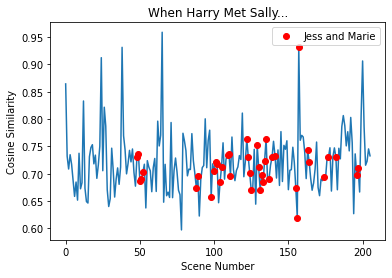

When Harry Met Sally... 전체 평균 tensor([[0.7210]]) B스토리 평균 tensor([[0.7139]]) B스토리 제외 평균 tensor([[0.7228]])
166 40 206


In [17]:
for movie_name in mov_emb.keys():
    print(movie_name)
    pairs = []
    scene_nums = []
    scores = []
    critical_point = 0
    mean = torch.mean(torch.tensor(mov_emb[movie_name]),dim=0)
    for scene_num, emb in enumerate(mov_emb[movie_name]):
        score = util.cos_sim(mean,emb)   
        pairs.append({'index': scene_num, 'score': score})

    pairs = sorted(pairs, key=lambda x: x['index'], reverse=False)
    #    pred = []
    for k, pair in enumerate(pairs):
        scene_num = pair['index']
        print("mean \t\t {} \t\t Score: {:.4f}".format(mov_scene[movie_name][scene_num], pair['score'].item()))
        scene_nums.append(pair['index'])
        scores.append(pair['score'])
        if pair['score']> 0.9 and critical_point == 0:
            critical_point = mov_scene[movie_name][scene_num]

    #    if pair['score']>0.9:
    #        break
    #        pred.append(node[j])  
    
    x = scene_nums
    y = scores
    x_p = []
    y_p = []
    y_p_except = []
    for i, num in enumerate(scene_nums):
        for pro in pro_scene:            
            if int(mov_scene[movie_name][num][6:])==pro:
                x_p.append(num)
                y_p.append(scores[i])
                
    for score in y:
        if score not in y_p:
            y_p_except.append(score)
    plt.plot(x,y)
    plt.plot(x_p,y_p,'o',color='red',label='Jess and Marie')
    plt.legend(loc='upper right')
    plt.xlabel('Scene Number')
    plt.ylabel('Cosine Similarity')
    plt.title(movie_name)
    plt.savefig(movie_name+'_Bstory.png',dpi=300)
    plt.show()
    print(movie_name, '전체 평균',sum(scores)/len(scores),'B스토리 평균',sum(y_p)/len(y_p),'B스토리 제외 평균',sum(y_p_except)/len(y_p_except))
    print(len(y_p_except),len(y_p),len(y))

#    print(tripod[tripod['movie_name']==movie_name]['tp1'],tripod[tripod['movie_name']==movie_name]['tp2'])
            
    #    score[node[scene_num]].append(pred)

In [25]:
mov.scene_dict[123]

{'JESS': [' I like it, it works. It says home to me.'],
 'MARIE': [" Alright, alright. We'll let Harry and Sally ( e the judge. (To Harry and Sally) What do you think"]}